In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
import scipy as sp

In [2]:
!ls ../raw

public.test.csv    public.train.csv   submit_example.csv


In [3]:
df_train = pd.read_csv('../raw/public.train.csv')
df_test = pd.read_csv('../raw/public.test.csv')
submission = pd.read_csv('../raw/submit_example.csv')

In [4]:
df_train.shape, df_test.shape

((9000, 21), (8409, 20))

## checking the null values

In [5]:
df_train.isnull().sum().sort_values(ascending = False)

发电量      0
电压B      0
板温       0
现场温度     0
光照强度     0
转换效率     0
转换效率A    0
转换效率B    0
转换效率C    0
电压A      0
电压C      0
风向       0
电流A      0
电流B      0
电流C      0
功率A      0
功率B      0
功率C      0
平均功率     0
风速       0
ID       0
dtype: int64

没有缺值

## Checking the Target

In [7]:
df_train['发电量'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: 发电量, dtype: float64

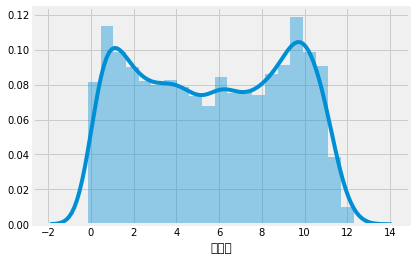

In [8]:
sns.distplot(df_train['发电量'])

## 检查并删除离群点

**板温**

In [9]:
df_train['板温'].describe()

count    9000.000000
mean        6.703914
std        11.742366
min       -24.790000
25%        -1.870000
50%         5.640000
75%        15.620000
max        36.490000
Name: 板温, dtype: float64

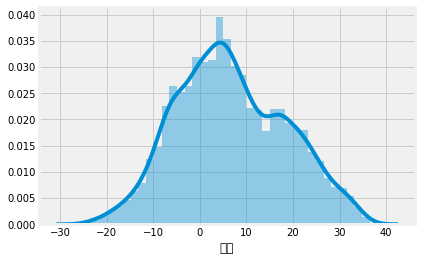

In [11]:
sns.distplot(df_train['板温'])

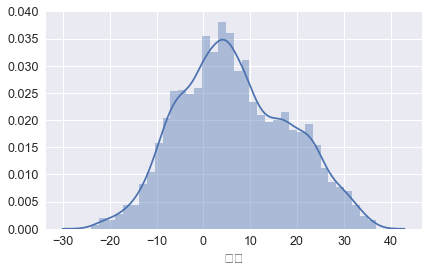

In [91]:
sns.distplot(df_test['板温'])

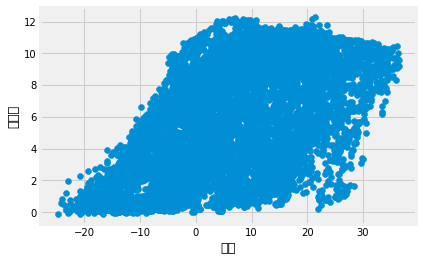

In [12]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['板温'], y = df_train['发电量'])
plt.ylabel('发电量', fontsize=13)
plt.xlabel('板温', fontsize=13)
plt.show()

In [13]:
def plot_points(feature):
    fig, ax = plt.subplots()
    ax.scatter(x = df_train[feature], y = df_train['发电量'])
    plt.ylabel('发电量', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show()

**现场温度**

In [14]:
df_train['现场温度'].describe()

count    9000.000000
mean       -0.629456
std        67.430126
min     -6321.700000
25%        -7.600000
50%        -2.400000
75%         8.100000
max        78.700000
Name: 现场温度, dtype: float64

In [161]:
# df_train.loc[5890,'现场温度'] = 0.3
# df_train.loc[593,'现场温度'] = 0.44
# df_train.loc[1127,'现场温度'] = 0.20
# df_train.loc[1689,'现场温度'] = 0.21
# df_train.loc[1690,'现场温度'] = 0.21
# df_train.loc[1782,'现场温度'] = 0.12
# df_train.loc[246,'现场温度'] = 0.48
# df_train.loc[1480,'现场温度'] = 0.42

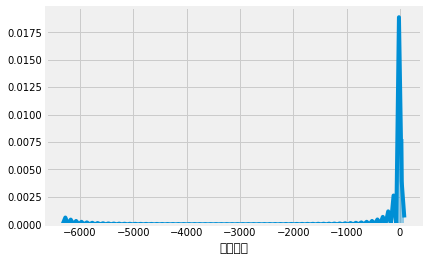

In [16]:
sns.distplot(df_train['现场温度'])

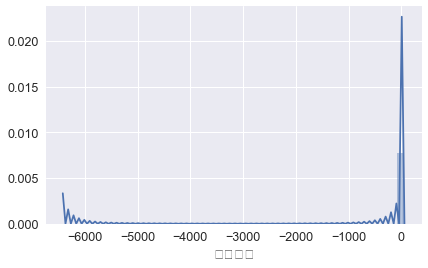

In [92]:
sns.distplot(df_test['现场温度'])

In [96]:
df_test[df_test['现场温度'] < -100]

,ID,板温,现场温度,光照强度,转换效率,转换效率A,转换效率B,转换效率C,电压A,电压B,...,电流A,电流B,电流C,功率A,功率B,功率C,平均功率,风速,风向,发电量
253,595,0.00,-142.1,34,15109.77,25.58,27.00,45276.72,37,39,...,6.77,6.78,6.78,250.49,264.42,443452.68,147989.20,16.0,41,7.033700
763,1717,0.06,-156.4,20,25828.88,42.54,47.41,77396.68,36,40,...,6.81,6.83,6.82,245.16,273.20,446000.72,148839.69,12.1,22,7.049060
3331,7437,0.17,-6414.2,627,792.66,40.19,29.43,2308.37,807,831,...,9.00,6.40,6.37,7263.00,5318.40,417177.67,143253.02,2.4,619,11.767877


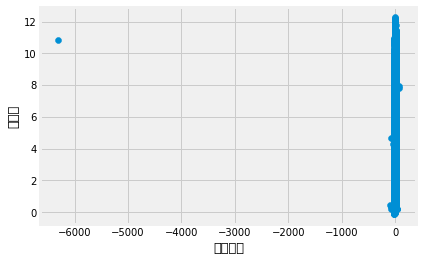

In [18]:
plot_points('现场温度')

## 离群点严重影响图形, 删除掉

* 首先删除掉温度小于 -6000° 的点

In [23]:
df_train = df_train.drop(df_train[df_train['现场温度'] < -100].index)

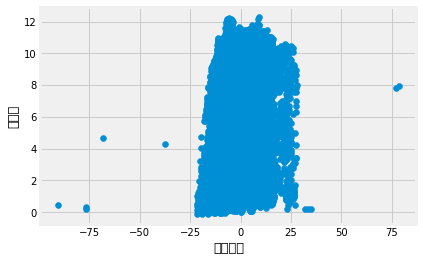

In [24]:
plot_points('现场温度')

* 继续删掉小于 -25° 和 大于 30° 的离群点

In [35]:
df_train = df_train.drop(df_train[(df_train['现场温度'] < -25)|(df_train['现场温度'] > 30)].index)

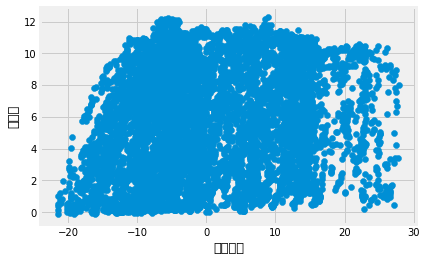

In [36]:
plot_points('现场温度')

**光照强度**

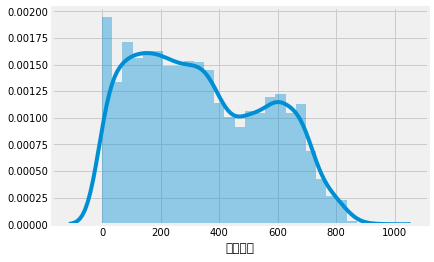

In [37]:
sns.distplot(df_train['光照强度'])

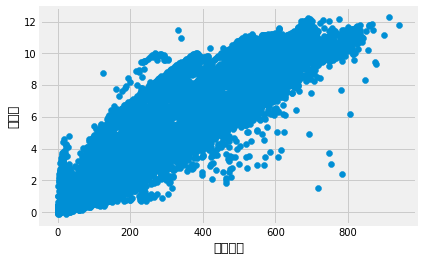

In [38]:
plot_points('光照强度')

In [42]:
df_train = df_train.drop(df_train[(df_train['光照强度'] > 700)&(df_train['发电量'] < 4)].index)

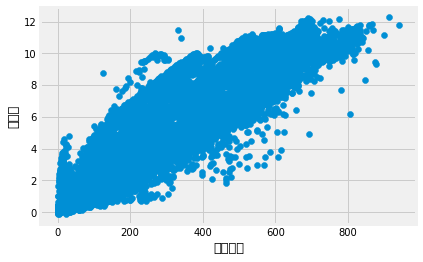

In [43]:
plot_points('光照强度')

* 删除 4 个离群点

**转换效率**

In [63]:
df_train['转换效率'].describe()

count    8951.000000
mean       34.988010
std        46.920175
min         0.000000
25%        20.495000
50%        25.160000
75%        36.915000
max       763.590000
Name: 转换效率, dtype: float64

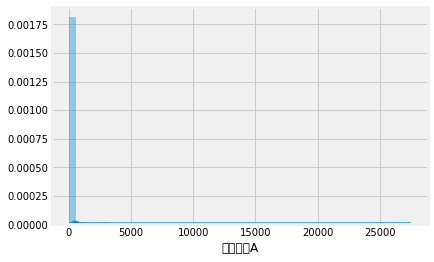

In [45]:
sns.distplot(df_train['转换效率A'])

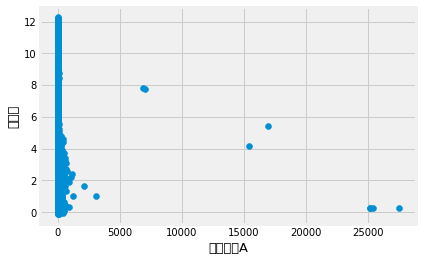

In [46]:
plot_points('转换效率A')

In [55]:
df_train = df_train.drop(df_train[df_train['转换效率A'] >800].index)

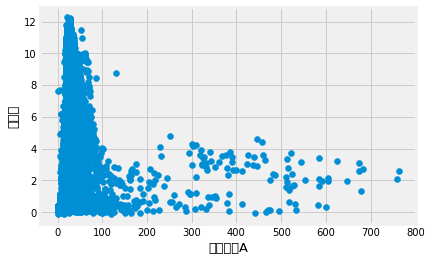

In [56]:
plot_points('转换效率A')

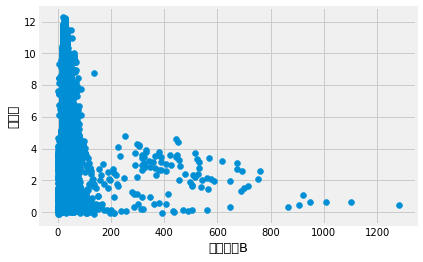

In [57]:
plot_points('转换效率B')

In [58]:
df_train = df_train.drop(df_train[df_train['转换效率B'] > 800].index)

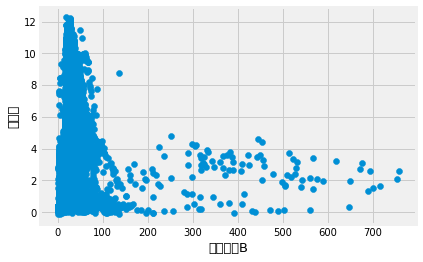

In [59]:
plot_points('转换效率B')

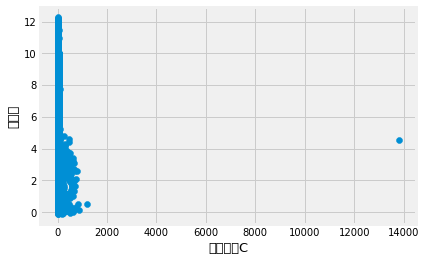

In [60]:
plot_points('转换效率C')

In [61]:
df_train = df_train.drop(df_train[df_train['转换效率C'] > 800].index)

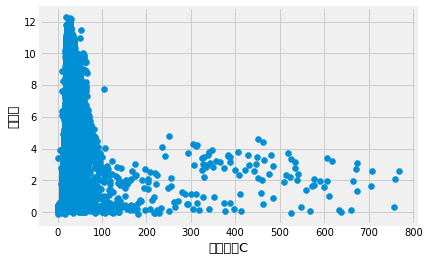

In [62]:
plot_points('转换效率C')

**电压**

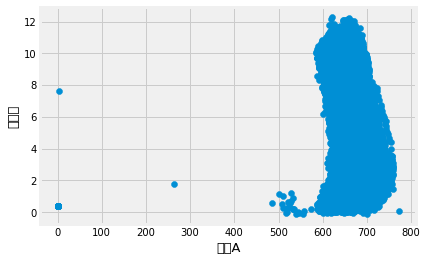

In [65]:
plot_points('电压A')

先去掉电压A 小于 400 的

In [67]:
df_train = df_train.drop(df_train[df_train['电压A'] < 400].index)

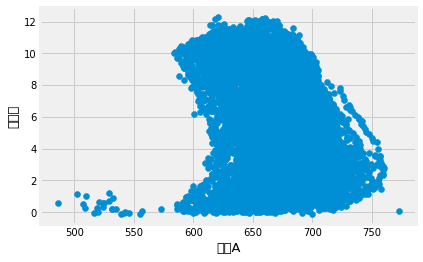

In [68]:
plot_points('电压A')

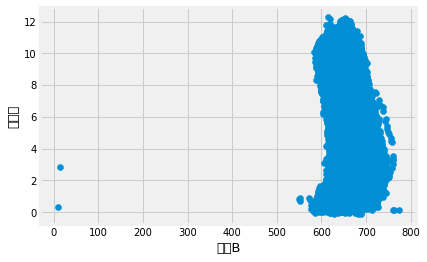

In [69]:
plot_points('电压B')

In [70]:
df_train[df_train['电压B'] < 400]

,ID,板温,现场温度,光照强度,转换效率,转换效率A,转换效率B,转换效率C,电压A,电压B,...,电流A,电流B,电流C,功率A,功率B,功率C,平均功率,风速,风向,发电量
2116,4401,-8.45,-8.9,90,7.81,9.80,0.63,13.01,667,9,...,0.37,1.77,3.31,246.79,15.93,327.69,196.80,0.6,319,0.323052
2863,5939,-9.98,-12.6,130,22.91,57.08,1.47,10.18,715,15,...,2.89,3.54,2.69,2066.35,53.10,368.53,829.33,1.6,273,2.858739


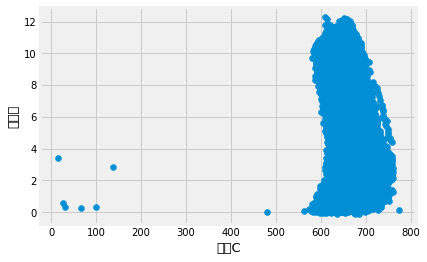

In [71]:
plot_points('电压C')

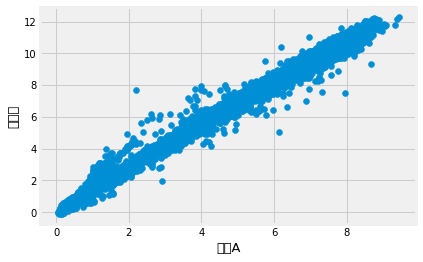

In [72]:
plot_points('电流A')

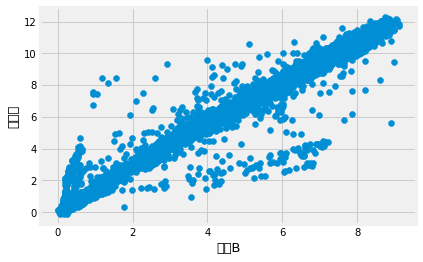

In [73]:
plot_points('电流B')

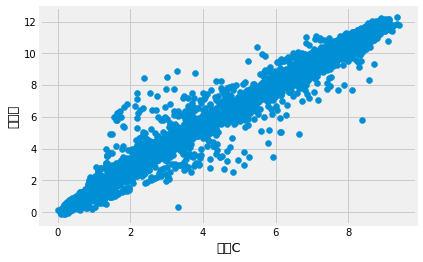

In [74]:
plot_points('电流C')

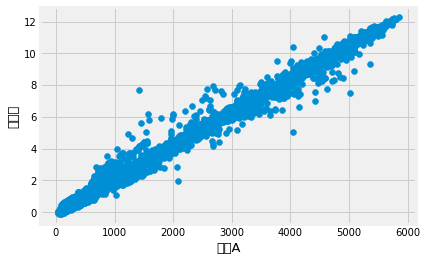

In [75]:
plot_points('功率A')

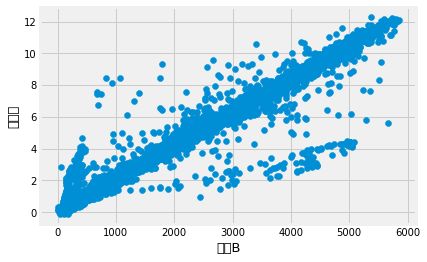

In [76]:
plot_points('功率B')

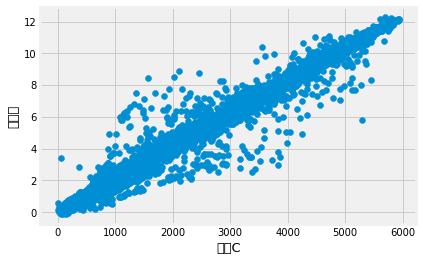

In [77]:
plot_points('功率C')

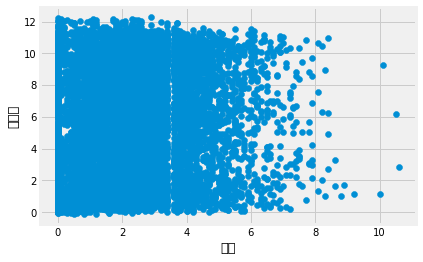

In [78]:
plot_points('风速')

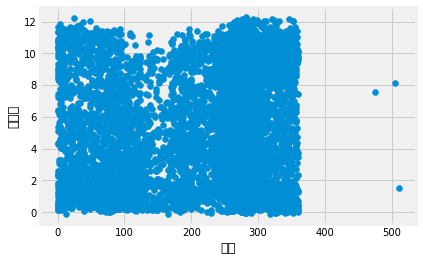

In [79]:
plot_points('风向')

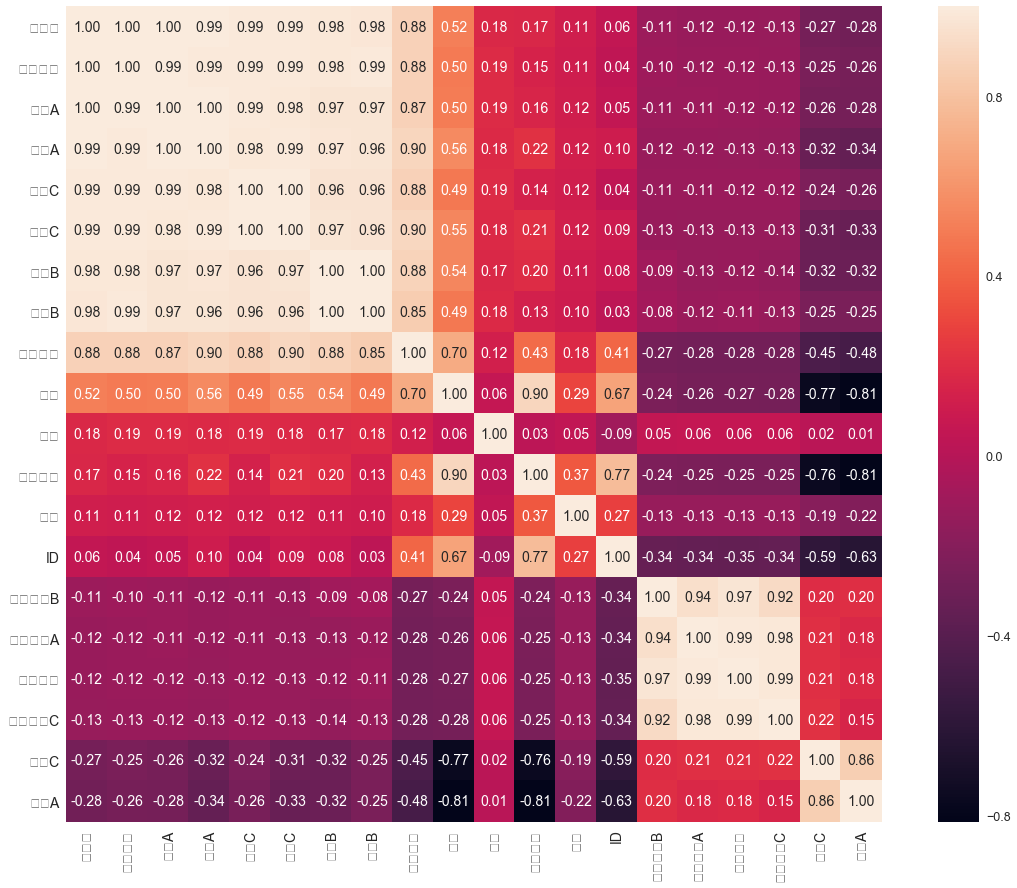

In [80]:
# 热力散点图
k = 20 #number of stdiables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, '发电量')['发电量'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [81]:
labels = df_train.发电量

In [82]:
train = df_train.drop(['ID','发电量'], axis=1)

In [83]:
scores = []
for i in range(5):    
    train_X, test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.15)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算`
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 6, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    score = 1 / (1 + rmsetmp)
    print('This time score is: '+ str(score))
    scores.append(score)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean score of these is:' + str(Get_Average(scores)))

This time score is: 0.8872695898762535
This time score is: 0.9042031944657825
This time score is: 0.877701097151963
This time score is: 0.9096987605054586
This time score is: 0.8770622807270194
Mean score of these is:0.8911869845452955


- step1: max_depth=6 score=0.8509 结果 0.8256
- step2: max_depth=5 score=0.8370 
- step3: max_depth=7 score=0.8592 结果 0.8217

### 清洗数据表格过后
- step1: max_depth=6 score=0.8911 结果 0.8256

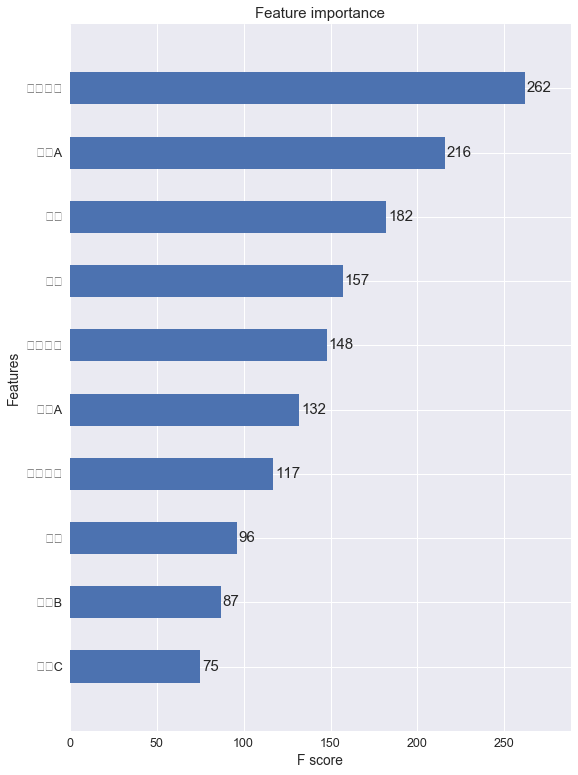

In [84]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax)

In [86]:
test = df_test.drop(['ID'], axis=1)

In [87]:
test_set = xgb.DMatrix(test)
prediction = model.predict(test_set)

In [88]:
df_test['发电量'] = prediction

In [89]:
submit = df_test[['ID', '发电量']]

In [90]:
submit.to_csv('./results/result_20180731a_xgboost-baseline.csv',index=False, header=False)  

## lightGBM

In [119]:
import lightgbm as lgb

In [136]:
scores = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.15)
    
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_test = lgb.Dataset(test_X, test_y)
    
    params = {
    'learning_rate': 0.002,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.8,
    'num_leaves': 35,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,}
    
    gbm = lgb.train(params,lgb_train, 3500)
    pred = gbm.predict(test_X)
    rmsetmp = sp.sqrt(sp.mean((test_y - pred) ** 2))
    score = 1 / (1 + rmsetmp)
    
    print('This time score is: '+ str(score))
    scores.append(score)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(scores)))

This time score is: 0.8243276220980186
This time score is: 0.862045330830996
This time score is: 0.8565425084240275
This time score is: 0.8708391699433029
This time score is: 0.663138588351107
Mean rmse of these is:0.8153786439294904


In [ ]:
round=900 score=0.6458
round=1000 score=0.6473
round=2000 score=0.8104
round=2500 score=0.8456
round=3000 score=0.8586 线上 0.8276
round=3500 score=0.8153 

In [127]:
prediction2 = gbm.predict(test)

In [130]:
df_test['发电量'] = prediction2

In [131]:
submit = df_test[['ID', '发电量']]

In [132]:
submit.to_csv('./results/result_20180730a_lightgbm-baseline.csv',index=False, header=False)  

In [134]:
rmse = sp.sqrt(sp.mean((prediction - prediction2) ** 2))
score = 1 / (1 + rmse)

In [135]:
score

0.8972961895270576